In [1]:
import numpy as np
import sep
import matplotlib.pyplot as plt
from matplotlib import rcParams
from astropy.io import fits

%matplotlib inline

rcParams['figure.figsize'] = [10.,8.]

In [2]:
with fits.open('jw02731-o001_t017_nircam_clear-f090w_i2d.fits') as hdul:
    hdul.info()

Filename: jw02731-o001_t017_nircam_clear-f090w_i2d.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     365   ()      
  1  SCI           1 ImageHDU        75   (14339, 8582)   float32   
  2  ERR           1 ImageHDU        10   (14339, 8582)   float32   
  3  CON           1 ImageHDU        10   (14339, 8582, 6)   int32   
  4  WHT           1 ImageHDU         9   (14339, 8582)   float32   
  5  VAR_POISSON    1 ImageHDU         9   (14339, 8582)   float32   
  6  VAR_RNOISE    1 ImageHDU         9   (14339, 8582)   float32   
  7  VAR_FLAT      1 ImageHDU         9   (14339, 8582)   float32   
  8  HDRTAB        1 BinTableHDU    532   160R x 261C   [23A, 5A, 3A, 45A, 6A, 13A, 7A, 5A, 6A, 7A, 10A, 4A, L, D, D, 32A, 50A, 32A, 21A, 3A, 3A, 10A, 12A, 23A, 23A, 26A, 11A, 5A, 3A, 3A, 2A, 1A, 2A, 1A, L, 14A, 23A, 2A, 26A, 20A, 27A, 10A, K, L, L, L, L, 8A, 8A, 5A, D, D, D, D, D, D, 27A, D, D, 6A, 5A, 1A, 5A, 5A, 5A, L, 4A, K, 5A, 9A, D, D, D

In [3]:
hdul = fits.open('jw02731-o001_t017_nircam_clear-f090w_i2d.fits')
data = hdul[1].data
masked_data = np.ma.masked_invalid(data)

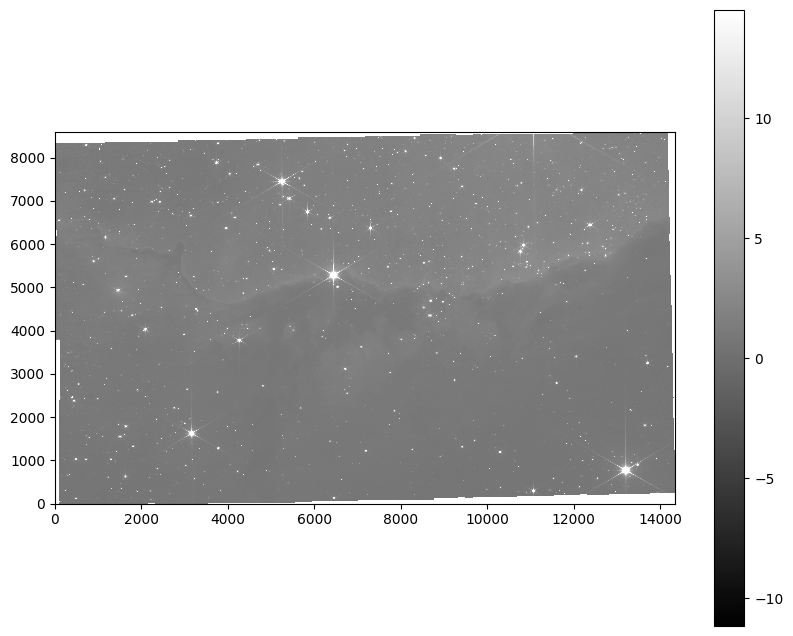

In [4]:
m, s = np.mean(masked_data), np.std(masked_data)
plt.imshow(data, interpolation = 'nearest', cmap = 'gray', vmin = m - s, vmax = m + s, origin = 'lower')
plt.colorbar();
plt.savefig('image display1.png')

In [5]:
masked_data = data.astype(data.dtype.newbyteorder('='))
bkg = sep.Background(masked_data)

In [6]:
print(bkg.globalback)
print(bkg.globalrms)

1.1956995725631714
0.06582547724246979


In [7]:
bkg_image = bkg.back()

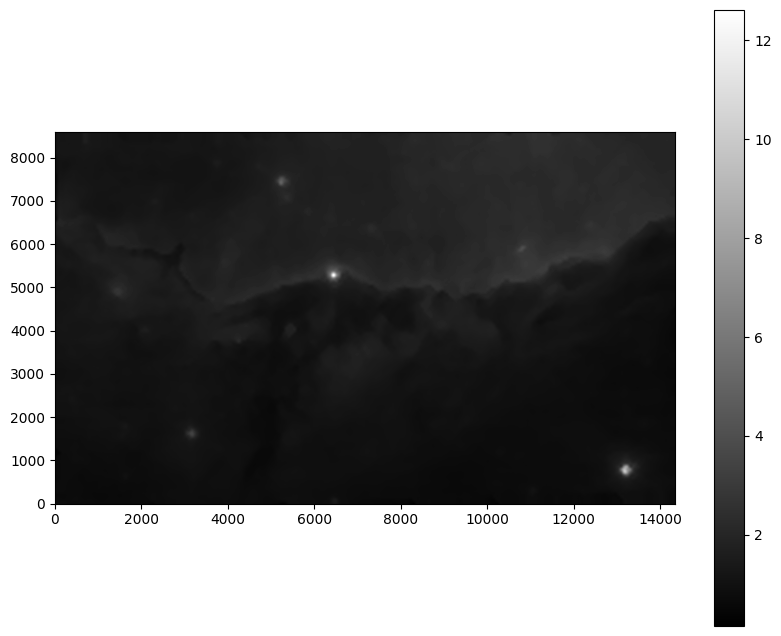

In [8]:
plt.imshow(bkg_image, interpolation = 'nearest', cmap = 'gray', origin = 'lower')
plt.colorbar();
plt.savefig('background1.png')

In [9]:
bkg_rms = bkg.rms()

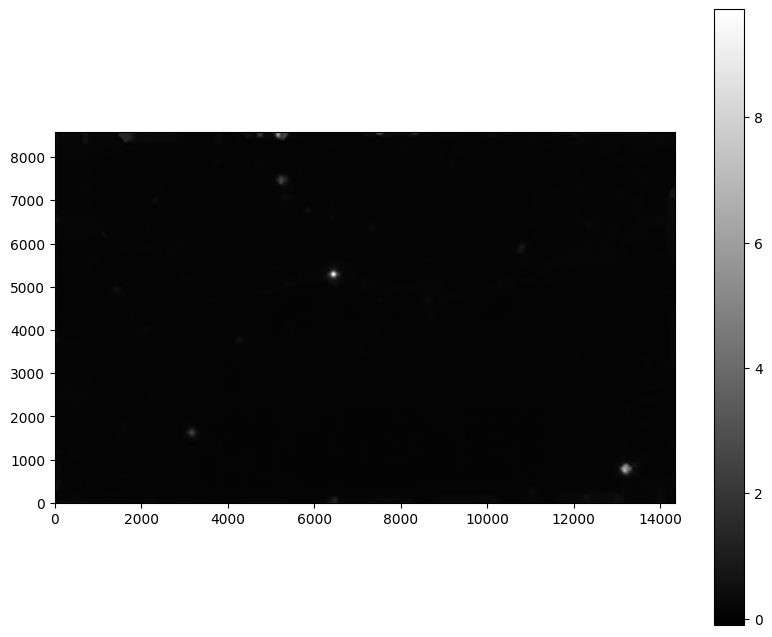

In [10]:
plt.imshow(bkg_rms, interpolation = 'nearest', cmap = 'gray', origin = 'lower')
plt.colorbar();
plt.savefig('background noise1.png')

In [11]:
data_sub = masked_data - bkg

In [12]:
objects = sep.extract(data_sub, 10, err = bkg.globalrms)

In [13]:
len(objects)

12016

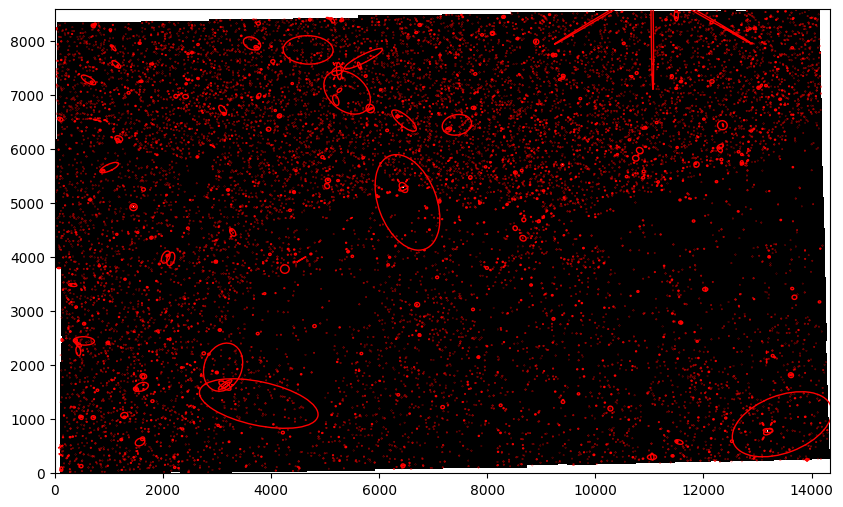

In [14]:
from matplotlib.patches import Ellipse

#plot the image without the background
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation = 'nearest', cmap = 'gray', vmin = m - s, vmax = m + s, origin = 'lower')

#creates the ellipses
for i in range(len(objects)):
    e = Ellipse(xy = (objects['x'][i], objects['y'][i]),
                width = 6 * objects ['a'][i],
                height = 6 * objects ['b'][i],
                angle = objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

plt.savefig('object detection1.png')

In [15]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'], 3.0, err = bkg.globalrms, gain = 1.0)

In [16]:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 36.514958 +/- 6.052934
object 1: flux = 10.580278 +/- 3.271436
object 2: flux = 249.279545 +/- 15.792458
object 3: flux = 35.355510 +/- 5.956287
object 4: flux = 472.214315 +/- 21.733312
object 5: flux = 13.704591 +/- 3.718461
object 6: flux = 55.563688 +/- 7.462332
object 7: flux = 79.149599 +/- 8.903490
object 8: flux = 19.981370 +/- 4.483757
object 9: flux = 15.242723 +/- 3.919921


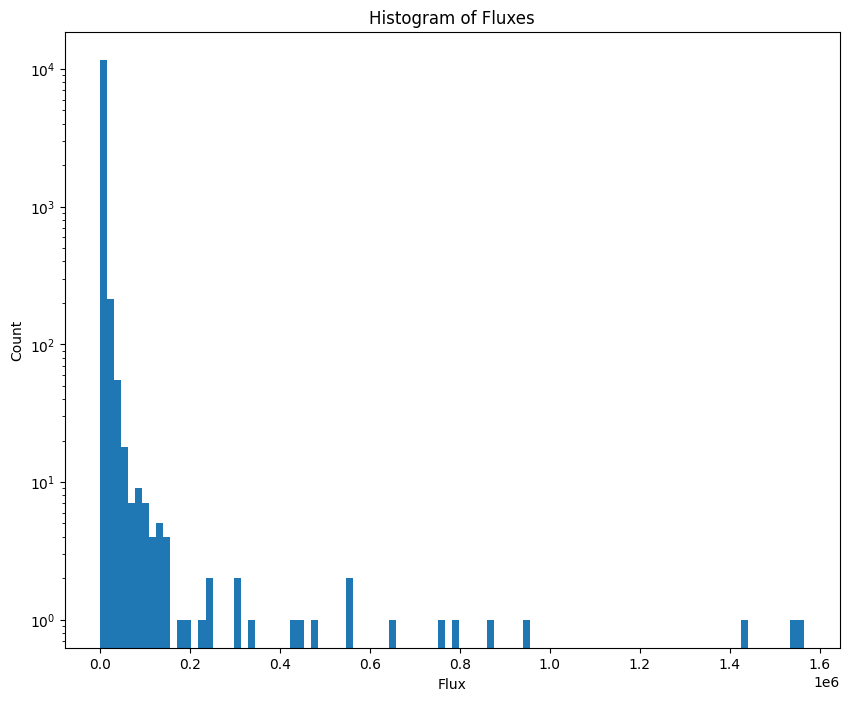

In [17]:
fluxes = np.array([obj['flux'] for obj in objects])
plt.hist(fluxes, bins=100, log=True)
plt.title("Histogram of Fluxes")
plt.xlabel("Flux")
plt.ylabel("Count")
plt.savefig("flux_histogram.png")

In [18]:
mean_flux = np.mean(fluxes)
median_flux = np.median(fluxes)
std_flux = np.std(fluxes)

outlier_index = np.argmax(fluxes)
outlier = objects[outlier_index]
outlier_sigma = (outlier['flux'] - mean_flux) / std_flux

print(f"The mean of the distribution of the fluxes is {mean_flux: .4f}.")
print(f"The median of the distribution of the fluxes is {median_flux: .4f}.")
print(f"The standard deviation of the distribution of the fluxes is {std_flux: .4f}.")
print(f"Largest outlier is at ({outlier['x']}, {outlier['y']}), flux={outlier['flux']}, {outlier_sigma:.2f}σ from mean")

The mean of the distribution of the fluxes is  2691.7734.
The median of the distribution of the fluxes is  59.9844.
The standard deviation of the distribution of the fluxes is  32327.2129.
Largest outlier is at (13195.695291273563, 769.9828656177108), flux=1565477.875, 48.34σ from mean


In [19]:
# ---------------------------------
# 0. Copy all this script into one cell, between steps 7 and 8 of your final project
#    You will need to install the "reproject" package with pip
#    This script will "reproject" all images onto the same shape using one image as a reference
# ---------------------------------

from astropy.io import fits
from astropy.wcs import WCS
from reproject import reproject_interp

# ---------------------------------
# 1. Load your reference image
#    This will define the WCS and shape for all others
# ---------------------------------
file_reference = 'jw02731-o001_t017_nircam_clear-f090w_i2d.fits'
with fits.open(file_reference) as hdulist:
    # For JWST i2d images, 'SCI' is commonly the science extension
    ref_header = hdulist['SCI'].header
    ref_data = hdulist['SCI'].data

# Create a WCS object from the reference
ref_wcs = WCS(ref_header)

# This shape will be used for all reprojected images
output_shape = ref_data.shape

# ---------------------------------
# 2. Reproject the other images
# ---------------------------------
fname1 = 'jw02731-o001_t017_nircam_clear-f187n_i2d.fits'
fname2 = 'jw02731-o001_t017_nircam_clear-f200w_i2d.fits'
fname3 = 'jw02731-o001_t017_nircam_clear-f335m_i2d.fits'
fname4 = 'jw02731-o001_t017_nircam_clear-f444w_i2d.fits'
fname5 = 'jw02731-o001_t017_nircam_f444w-f470n_i2d.fits'

other_filenames = [
    fname1,
    fname2,
    fname3,
    fname4,
    fname5,
]

# Reproject all other files according to the reference
for fname in other_filenames:
    with fits.open(fname) as hdulist:
        data = hdulist['SCI'].data
        header = hdulist['SCI'].header
        wcs_in = WCS(header)
    
    # Reproject this image onto the reference WCS
    # reproject_interp returns (reprojected_data, footprint)
    reprojected_data, footprint = reproject_interp(
        (data, wcs_in),
        ref_wcs,
        shape_out=output_shape
    )

    # Optionally, update the header to match the reference WCS
    # so that the new FITS is self-consistent
    new_header = ref_header.copy()

    # Save the new file
    out_name = fname.replace('.fits', '_reproj.fits')
    hdu = fits.PrimaryHDU(reprojected_data, header=new_header)
    hdu.writeto(out_name, overwrite=True)
    print(f"Reprojected {fname} -> {out_name}")

Set DATE-AVG to '2022-06-03T12:17:28.687' from MJD-AVG.
Set DATE-END to '2022-06-03T14:54:43.830' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.567170 from OBSGEO-[XYZ].
Set OBSGEO-H to 1654335564.228 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-03T11:43:37.007' from MJD-AVG.
Set DATE-END to '2022-06-03T14:26:16.631' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.557313 from OBSGEO-[XYZ].
Set OBSGEO-H to 1654186065.609 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Reprojected jw02731-o001_t017_nircam_clear-f187n_i2d.fits -> jw02731-o001_t017_nircam_clear-f187n_i2d_reproj.fits


Set DATE-AVG to '2022-06-03T12:45:26.326' from MJD-AVG.
Set DATE-END to '2022-06-03T15:22:38.772' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.574431 from OBSGEO-[XYZ].
Set OBSGEO-H to 1654445751.087 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Reprojected jw02731-o001_t017_nircam_clear-f200w_i2d.fits -> jw02731-o001_t017_nircam_clear-f200w_i2d_reproj.fits


Set DATE-AVG to '2022-06-03T12:17:28.706' from MJD-AVG.
Set DATE-END to '2022-06-03T14:54:43.830' from MJD-END'. [astropy.wcs.wcs]


Reprojected jw02731-o001_t017_nircam_clear-f335m_i2d.fits -> jw02731-o001_t017_nircam_clear-f335m_i2d_reproj.fits


Set DATE-AVG to '2022-06-03T12:45:26.346' from MJD-AVG.
Set DATE-END to '2022-06-03T15:22:38.772' from MJD-END'. [astropy.wcs.wcs]


Reprojected jw02731-o001_t017_nircam_clear-f444w_i2d.fits -> jw02731-o001_t017_nircam_clear-f444w_i2d_reproj.fits


Set DATE-AVG to '2022-06-03T11:43:37.025' from MJD-AVG.
Set DATE-END to '2022-06-03T14:26:16.695' from MJD-END'. [astropy.wcs.wcs]


Reprojected jw02731-o001_t017_nircam_f444w-f470n_i2d.fits -> jw02731-o001_t017_nircam_f444w-f470n_i2d_reproj.fits


In [20]:
fdata_f187 = 'jw02731-o001_t017_nircam_clear-f187n_i2d_reproj.fits'
fdata_f200 = 'jw02731-o001_t017_nircam_clear-f200w_i2d_reproj.fits'
fdata_f335 = 'jw02731-o001_t017_nircam_clear-f335m_i2d_reproj.fits'
fdata_f444 = 'jw02731-o001_t017_nircam_clear-f444w_i2d_reproj.fits'
fdata_f470 = 'jw02731-o001_t017_nircam_f444w-f470n_i2d_reproj.fits'

hdu_2 = fits.open(fdata_f187)
hdu_3 = fits.open(fdata_f200)
hdu_4 = fits.open(fdata_f335)
hdu_5 = fits.open(fdata_f444)
hdu_6 = fits.open(fdata_f470)

hdu_2.info()
hdu_3.info()
hdu_4.info()
hdu_5.info()
hdu_6.info()


Filename: jw02731-o001_t017_nircam_clear-f187n_i2d_reproj.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (14339, 8582)   float64   
Filename: jw02731-o001_t017_nircam_clear-f200w_i2d_reproj.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (14339, 8582)   float64   
Filename: jw02731-o001_t017_nircam_clear-f335m_i2d_reproj.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (14339, 8582)   float64   
Filename: jw02731-o001_t017_nircam_clear-f444w_i2d_reproj.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (14339, 8582)   float64   
Filename: jw02731-o001_t017_nircam_f444w-f470n_i2d_reproj.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (14339, 8582)   float64   


In [21]:
data_2 = hdu_2[0].data
data_3 = hdu_3[0].data
data_4 = hdu_4[0].data
data_5 = hdu_5[0].data
data_6 = hdu_6[0].data

In [22]:
def rescale_image(data,vmin=0.5,vmax=100):
    # copy the data to avoid accidentaly overwriting it
    data_tmp = data.copy()

    # compute the mean value over all data, excluding NaN (Not a Number)
    m = np.nanmean(data_tmp)

    # any data points below vpmin is assigned the value vpmin
    # any data points above vpmax is assigned the value vpmax
    vpmin = vmin * m
    vpmax = vmax * m
    data_tmp[data_tmp < vpmin] = vpmin
    data_tmp[data_tmp > vpmax] = vpmax
    
    # replace all NaN by vpmin
    data_tmp = np.nan_to_num(data_tmp,nan=vpmin)

    # apply log-scale
    data_tmp = np.log10(data_tmp)
    return data_tmp

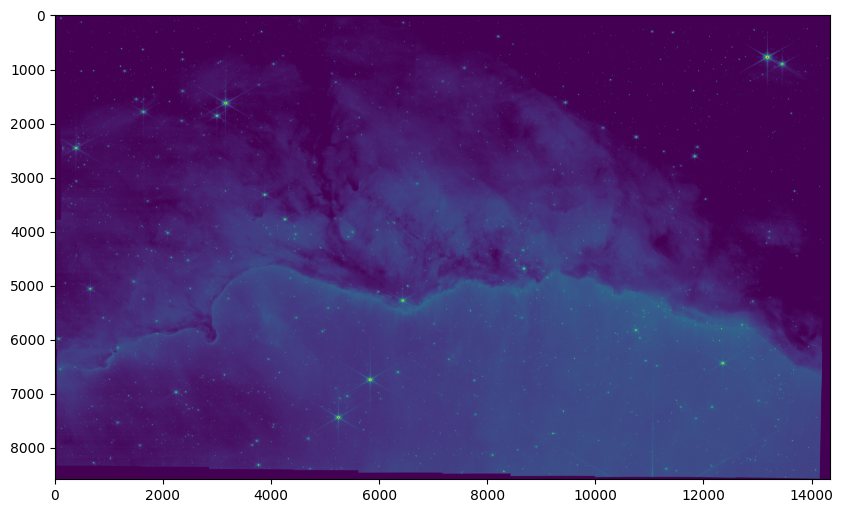

In [23]:
f = plt.figure(figsize=(10,8))

data_res = rescale_image(data_2)
data_res1 = rescale_image(data_3)
data_res2 = rescale_image(data_4)
data_res3 = rescale_image(data_5)
data_res4 = rescale_image(data_6)

plt.imshow(data_res)

In [24]:
### Let's combine the data into a single object, where each layer will correspond to a color
data_all = np.zeros((data_2.shape[0],data_2.shape[1],3))

data_all[:,:,0] = data_2 + data_5 #red is filter F277W
data_all[:,:,1] = data_3 + data_6 #green is filter F356W
data_all[:,:,2] = data_4 + masked_data #blue is filter F444W

# rescale the data so we can see features
# try different values of vmin and vmax!
data_all_res = rescale_image(data_all)

In [25]:
def remap(data):
    #copy the data to avoid accidently overwriting it
    data_tmp = data.copy()

    dmin = data_tmp.min()
    dmax = data_tmp.max()
    return (data_tmp - dmin)/(dmax-dmin)

In [26]:
rgb_image = np.zeros((data_2.shape[0],data_2.shape[1],3))

rgb_image = remap(data_all_res)

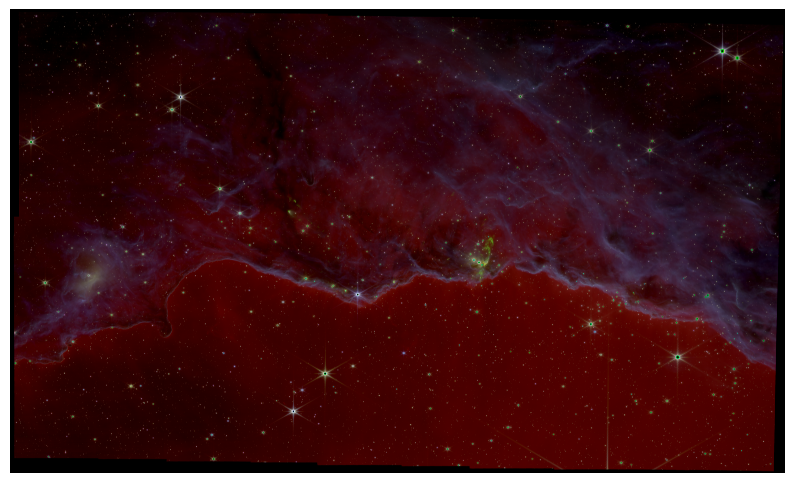

In [27]:
f,ax = plt.subplots(1,1,figsize=(10,8))
ax.axis('off')
ax.imshow(rgb_image)

plt.savefig('jwst_image.png',bbox_inches='tight',pad_inches=0,dpi=600)